# Adaptive Rejection Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from numpy.random import seed

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
a, b = 3, 2
p = beta(a=a, b=b)

In [4]:
seed(31)
z0 = p.rvs(3)

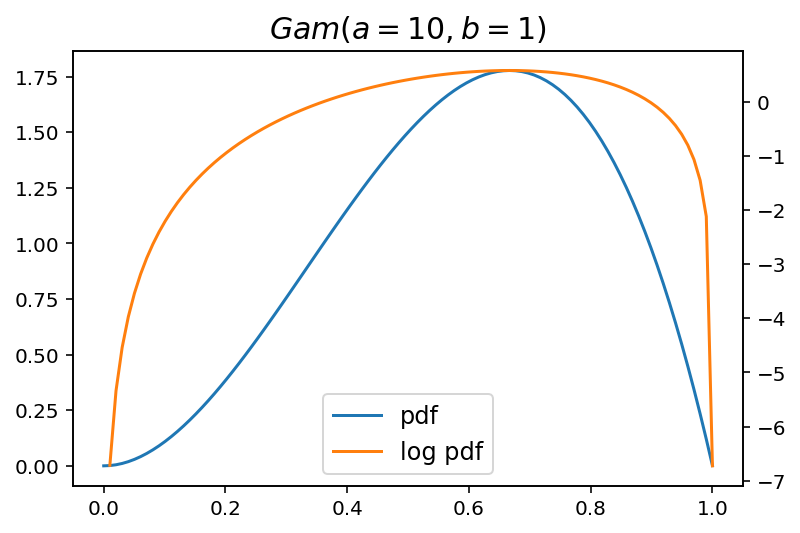

In [5]:
xrange = np.linspace(0, 0.9999, 100)

fig, ax = plt.subplots()
ax2 = ax.twinx()
l1 = ax.plot(xrange, p.pdf(xrange), label="pdf")
l2 = ax2.plot(xrange, p.logpdf(xrange), c="tab:orange", label="log pdf")
l = l1 + l2
labels = [l.get_label() for l in l]
ax.set_title(r"$Gam(a=10,b=1)$", fontsize=15)
plt.legend(l, labels, fontsize=12);

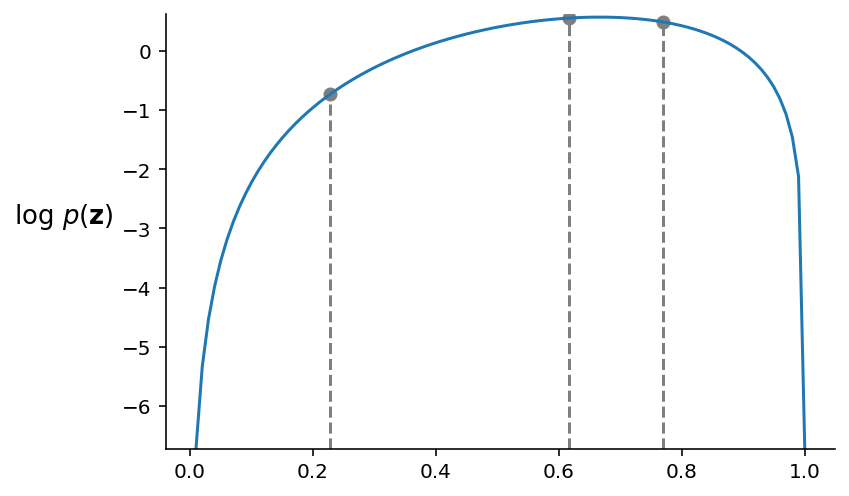

In [6]:
p_pdf = p.logpdf(xrange)

fig, ax = plt.subplots()
ax.plot(xrange, p_pdf, label="pdf")
ax.scatter(z0, p.logpdf(z0), color="tab:gray")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

lower_bound = p_pdf[~np.isinf(p_pdf)].min()
upper_bound = p_pdf.max() * 1.1
for z in z0:
    ax.vlines(z, lower_bound, p.logpdf(z), color="tab:gray", linestyle="--")
ax.set_ylim(lower_bound, upper_bound)
ax.set_ylabel(r"$\log \ p({\bf z})$", fontsize=13,
           rotation=0,
           horizontalalignment="right");

In [13]:
def finite_approx(f, x, eps=1e-5):
    return (f(x + eps) - f(x - eps)) / (2 * eps)

In [29]:
z = np.sort(z0)
lambda_n = finite_approx(p.logpdf, z)
lambda_n

array([ 7.47364841,  0.63678314, -1.73594703])

In [32]:
zrange = np.linspace(0, 1, 100)

In [55]:
if z_in < z.min():
    

array([0.22807336, 0.61648134, 0.76934868])